# Librerías


In [55]:
import pandas as pd
import matplotlib.pyplot as plt
from arima import (
    naive_model,
    arima_rolling_training_rolling_prediction,
    sarima_rolling_training_rolling_prediction,
    plot_arima,
)

from sklearn.metrics import root_mean_squared_error

# skforecast
from skforecast.Sarimax import Sarimax
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax

# statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX


# pmdarima
from pmdarima import auto_arima, ARIMA

## Leemos la data


In [32]:
train_df = pd.read_parquet("../../../data/time_series/train_df.parquet").asfreq("D")
validation_df = pd.read_parquet(
    "../../../data/time_series/validation_df.parquet"
).asfreq("D")
test_df = pd.read_parquet("../../../data/time_series/test_df.parquet").asfreq("D")

In [33]:
train_and_validation_df = pd.concat([train_df, validation_df])
df = pd.concat([train_df, validation_df, test_df])

# Arima optimo

Primero vamos a encontrar el modelo ARIMA óptimo para la serie de tiempo. Para esto vamos a utilizar la función auto_arima de la librería pmdarima.


In [34]:
model_pmd_arima = auto_arima(
    train_and_validation_df["gap"],
    max_p=10,
    m=7,
    maxiter=500,
    seasonal=True,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=False,
)

# Resumen del modelo
print(model_pmd_arima.summary())

 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=99887.337, Time=0.05 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=99794.054, Time=0.26 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=99752.054, Time=0.76 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=99775.645, Time=0.17 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=3.36 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=8.50 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=99729.984, Time=0.60 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=13.28 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=12.80 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=98516.902, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=98305.309, Time=0.49 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=98252.337, Time=1.90 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=98259.222, Time=0.38 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=4.45 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=12.39 sec
 ARIMA(0,1,1)(2,0,0)[7] inte

In [35]:
arima_order = (0, 1, 3)
seasonal_order = (2, 0, 0, 7)

# Model Building

## Naive model


In [36]:
rmse_naive, mape_naive = naive_model(
    train_df=train_df, test_df=validation_df, column_name="gap"
)

Naive approach:
RMSE: 16268.436428659435
MAPE: 17.11%


## Arima statsmodels


In [37]:
model = SARIMAX(
    endog=train_df["gap"], order=arima_order, seasonal_order=seasonal_order, freq="D"
)
model_res = model.fit(disp=0)
model_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                gap   No. Observations:                 4992
Model:             SARIMAX(0, 1, 3)x(2, 0, [], 7)   Log Likelihood              -48551.257
Date:                            Wed, 29 May 2024   AIC                          97114.513
Time:                                    14:17:06   BIC                          97153.605
Sample:                                11-01-2001   HQIC                         97128.216
                                     - 07-02-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6205      0.006   -110.432      0.000      -0.631      -0.609
ma.L2         -0.1900      0.007    -26.186      0.000      -0.204      -0.176
ma.L3          0.0182      0.006      3.300      0.001       0.007       0.029
ar.S.L7        0.2026      0.005     36.972      0.000       0.192       0.213
ar.S.L14       0.0841      0.005     16.055      0.000       0.074       0.094
sigma2      1.723e+07   9.53e-11   1.81e+17      0.000    1.72e+07    1.72e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            343570.60
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):             758.89   Skew:                             2.62
Prob(H) (two-sided):                  0.00   Kurtosis:                        43.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [38]:
predictions_statsmodels = model_res.get_forecast(
    steps=len(validation_df["gap"])
).predicted_mean
predictions_statsmodels.name = "predictions_statsmodels"

## Arima Skforecaster


In [39]:
model = Sarimax(order=arima_order, seasonal_order=seasonal_order)
model.fit(y=train_df["gap"])
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                gap   No. Observations:                 4992
Model:             SARIMAX(0, 1, 3)x(2, 0, [], 7)   Log Likelihood              -48551.257
Date:                            Wed, 29 May 2024   AIC                          97114.513
Time:                                    14:17:08   BIC                          97153.605
Sample:                                11-01-2001   HQIC                         97128.216
                                     - 07-02-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6205      0.006   -110.432      0.000      -0.631      -0.609
ma.L2         -0.1900      0.007    -26.186      0.000      -0.204      -0.176
ma.L3          0.0182      0.006      3.300      0.001       0.007       0.029
ar.S.L7        0.2026      0.005     36.972      0.000       0.192       0.213
ar.S.L14       0.0841      0.005     16.055      0.000       0.074       0.094
sigma2      1.723e+07   9.53e-11   1.81e+17      0.000    1.72e+07    1.72e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            343570.60
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):             758.89   Skew:                             2.62
Prob(H) (two-sided):                  0.00   Kurtosis:                        43.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [40]:
predictions_skforecast = model.predict(steps=len(validation_df["gap"]))
predictions_skforecast.columns = ["skforecast"]

## Modelo con pmdarima


In [56]:
pmd_arima = ARIMA(order=arima_order, seasonal_order=seasonal_order)
pmd_arima.fit(y=train_df["gap"])
pmd_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 4992
Model:             SARIMAX(0, 1, 3)x(2, 0, [], 7)   Log Likelihood              -48557.960
Date:                            Wed, 29 May 2024   AIC                          97129.920
Time:                                    14:24:24   BIC                          97175.528
Sample:                                11-01-2001   HQIC                         97145.906
                                     - 07-02-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     55.9678     13.178      4.247      0.000      30.139      81.796
ma.L1         -0.6179      0.006   -109.249      0.000      -0.629      -0.607
ma.L2         -0.1884      0.007    -25.974      0.000      -0.203      -0.174
ma.L3          0.0225      0.006      4.069      0.000       0.012       0.033
ar.S.L7        0.2000      0.005     36.829      0.000       0.189       0.211
ar.S.L14       0.0849      0.005     16.275      0.000       0.075       0.095
sigma2      1.722e+07      0.001   1.99e+10      0.000    1.72e+07    1.72e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            341215.43
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):             367.81   Skew:                             2.61
Prob(H) (two-sided):                  0.00   Kurtosis:                        43.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.77e+24. Standard errors may be unstable.
"""

In [57]:
predictions_pdmarima = pmd_arima.predict(len(validation_df["gap"]))
predictions_pdmarima.name = "predictions_pdmarima"

## Grafica de resultados


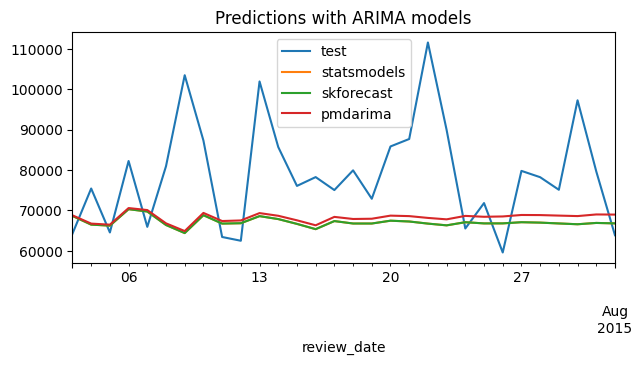

In [58]:
fig, ax = plt.subplots(figsize=(7, 3))
validation_df["gap"].plot(ax=ax, label="test")
predictions_statsmodels.plot(ax=ax, label="statsmodels")
predictions_skforecast.plot(ax=ax, label="skforecast")
predictions_pdmarima.plot(ax=ax, label="pmdarima")
ax.set_title("Predictions with ARIMA models")
ax.legend()

In [44]:
rmse_statsmodels = root_mean_squared_error(
    predictions_statsmodels, validation_df["gap"]
)
rmse_skforecast = root_mean_squared_error(predictions_skforecast, validation_df["gap"])
rmse_pmdarima = root_mean_squared_error(predictions_pdmarima, validation_df["gap"])

In [45]:
print(f"RMSE statsmodels: {rmse_statsmodels}")
print(f"RMSE skforecast: {rmse_skforecast}")
print(f"RMSE pmdarima: {rmse_pmdarima}")

RMSE statsmodels: 17521.08301136826
RMSE skforecast: 17521.08301136826
RMSE pmdarima: 13357.41939212745


## ARIMA rolling training rolling prediction utilizando VALIDATION


In [46]:
(
    mape_arima_rolling,
    rmse_arima_rolling,
    [predictions__arima_rolling, values__arima_rolling],
) = arima_rolling_training_rolling_prediction(
    train_df=train_df, test_df=validation_df, arima_order=arima_order, column="gap"
)

ARIMA Order: (0, 1, 3)
RMSE: 13338.399626325532
MAPE: 12.82%


In [47]:
plot_arima(
    test_df,
    values__arima_rolling,
    predictions__arima_rolling,
    title="Comparación de los valores reales con las predicciones del modelo ARIMA usando ROLLING TRAINING - ROLLING PREDICTIONS",
)

## Sarima Rolling training rolling prediction utilizando VALIDATION


In [48]:
(
    mape_arima_rolling,
    rmse_arima_rolling,
    [predictions__sarima_rolling, values__sarima_rolling],
) = sarima_rolling_training_rolling_prediction(
    train_df=train_df,
    test_df=validation_df,
    arima_order=arima_order,
    seasonal_order=seasonal_order,
    column="gap",
)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.73192D+00    |proj g|=  6.47694D-02


 This problem is unconstrained.



At iterate    5    f=  9.72582D+00    |proj g|=  2.29869D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     11      1     0     0   1.071D-05   9.726D+00
  F =   9.7258126033271850     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.73197D+00    |proj g|=  6.36580D-02


 This problem is unconstrained.



At iterate    5    f=  9.72582D+00    |proj g|=  7.11730D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      7     12      1     0     0   3.876D-05   9.726D+00
  F =   9.7258188464590365     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.73267D+00    |proj g|=  6.53573D-02


 This problem is unconstrained.



At iterate    5    f=  9.72638D+00    |proj g|=  2.06314D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     11      1     0     0   1.030D-05   9.726D+00
  F =   9.7263716577374471     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.73261D+00    |proj g|=  6.50552D-02

At iterate    5    f=  9.72643D+00    |proj g|=  1.68781D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     11      1     0     0   1.038D-05   9.726D+00
  F =   9.7264253901417757     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.73322D+00    |proj g|=  6.42035D-02

At iterate    5    f=  9.72733D+00    |proj g|=  1.68989D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     11      1     0     0   1.061D-05   9.727D+00
  F =   9.7273277971078951     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.73372D+00    |proj g|=  6.44857D-02

At iterate    5    f=  9.72771D+00    |proj g|=  2.09186D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     11      1     0     0   1.054D-05   9.728D+00
  F =   9.7277079600351186     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  9.72900D+00    |proj g|=  9.71153D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     13      1     0     0   1.043D-05   9.729D+00
  F =   9.7289981226322553     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.74069D+00    |proj g|=  6.04952D-02


 This problem is unconstrained.



At iterate    5    f=  9.73499D+00    |proj g|=  7.21453D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      7     12      1     0     0   1.173D-05   9.735D+00
  F =   9.7349859939499801     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.74035D+00    |proj g|=  6.08371D-02

At iterate    5    f=  9.73496D+00    |proj g|=  1.02511D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     11      1     0     0   9.724D-06   9.735D+00
  F =   9.7349594694420638     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.74264D+00    |proj g|=  6.35945D-02

At iterate    5    f=  9.73648D+00    |proj g|=  1.82693D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     11      1     0     0   9.479D-06   9.736D+00
  F =   9.7364682685221791     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  9.73687D+00    |proj g|=  1.28040D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     11      1     0     0   9.545D-06   9.737D+00
  F =   9.7368616064907521     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.74793D+00    |proj g|=  6.44043D-02


 This problem is unconstrained.



At iterate    5    f=  9.74087D+00    |proj g|=  1.59106D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     13      1     0     0   1.024D-05   9.741D+00
  F =   9.7408597396508654     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.74772D+00    |proj g|=  6.25639D-02


 This problem is unconstrained.



At iterate    5    f=  9.74080D+00    |proj g|=  1.79611D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     13      1     0     0   1.024D-05   9.741D+00
  F =   9.7407901285443721     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.74788D+00    |proj g|=  6.33715D-02


 This problem is unconstrained.



At iterate    5    f=  9.74086D+00    |proj g|=  1.78961D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     14      1     0     0   1.025D-05   9.741D+00
  F =   9.7408525177484275     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.74809D+00    |proj g|=  6.38338D-02


 This problem is unconstrained.



At iterate    5    f=  9.74088D+00    |proj g|=  3.50411D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     12      1     0     0   1.013D-05   9.741D+00
  F =   9.7408750730536191     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.74786D+00    |proj g|=  6.30009D-02


 This problem is unconstrained.



At iterate    5    f=  9.74091D+00    |proj g|=  4.54657D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     13      1     0     0   1.011D-05   9.741D+00
  F =   9.7409111317170627     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.74810D+00    |proj g|=  6.37887D-02


 This problem is unconstrained.



At iterate    5    f=  9.74094D+00    |proj g|=  1.92429D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     13      1     0     0   9.953D-06   9.741D+00
  F =   9.7409300367204779     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.74799D+00    |proj g|=  6.37005D-02


 This problem is unconstrained.



At iterate    5    f=  9.74094D+00    |proj g|=  1.72329D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     13      1     0     0   1.007D-05   9.741D+00
  F =   9.7409277636966642     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.74787D+00    |proj g|=  6.33090D-02


 This problem is unconstrained.



At iterate    5    f=  9.74091D+00    |proj g|=  1.77169D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      7     11      1     0     0   1.334D-04   9.741D+00
  F =   9.7408986365047525     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.74813D+00    |proj g|=  6.40154D-02

At iterate    5    f=  9.74109D+00    |proj g|=  1.69804D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     13      1     0     0   1.034D-05   9.741D+00
  F =   9.7410839102217270     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.75376D+00    |proj g|=  6.54355D-02

At iterate    5    f=  9.74603D+00    |proj g|=  2.69191D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     14      1     0     0   1.004D-05   9.746D+00
  F =   9.7460112512379169     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  9.74605D+00    |proj g|=  2.25603D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     12      1     0     0   9.986D-06   9.746D+00
  F =   9.7460341988899870     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.75627D+00    |proj g|=  6.76399D-02


 This problem is unconstrained.



At iterate    5    f=  9.74811D+00    |proj g|=  3.05654D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     13      1     0     0   9.763D-06   9.748D+00
  F =   9.7480912196511813     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.75645D+00    |proj g|=  6.80479D-02

At iterate    5    f=  9.74823D+00    |proj g|=  3.87028D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     13      1     0     0   9.750D-06   9.748D+00
  F =   9.7482092351598446     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.75732D+00    |proj g|=  6.61392D-02

At iterate    5    f=  9.75010D+00    |proj g|=  4.42092D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     11      1     0     0   1.165D-05   9.750D+00
  F =   9.7500788912642005     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  9.75001D+00    |proj g|=  6.68324D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      7     11      1     0     0   3.511D-05   9.750D+00
  F =   9.7500074440505493     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.75747D+00    |proj g|=  6.53462D-02


 This problem is unconstrained.



At iterate    5    f=  9.74996D+00    |proj g|=  5.42367D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      7     11      1     0     0   1.561D-04   9.750D+00
  F =   9.7499613795700615     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.75785D+00    |proj g|=  6.45588D-02


 This problem is unconstrained.



At iterate    5    f=  9.75018D+00    |proj g|=  6.76394D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     12      1     0     0   9.757D-06   9.750D+00
  F =   9.7501780152609072     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.76039D+00    |proj g|=  6.81118D-02

At iterate    5    f=  9.75254D+00    |proj g|=  2.66472D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     12      1     0     0   9.369D-06   9.753D+00
  F =   9.7525238026615568     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  9.75248D+00    |proj g|=  3.55249D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     14      1     0     0   9.484D-06   9.752D+00
  F =   9.7524459631407741     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA Order: (0, 1, 3)
Seasonal Order: (2, 0, 0, 7)
RMSE: 13221.351192802944
MAPE: 12.82%


In [49]:
plot_arima(
    validation_df,
    values__sarima_rolling,
    predictions__sarima_rolling,
    title="Comparación de los valores reales train vs validation con las predicciones del modelo SARIMA usando\n ROLLING TRAINING - ROLLING PREDICTIONS",
)

# Final model


In [50]:
(
    mape_sarima_rolling,
    rmse_sarima_rolling,
    [predictions__sarima_rolling, values__sarima_rolling],
) = sarima_rolling_training_rolling_prediction(
    train_df=train_and_validation_df,
    test_df=test_df,
    arima_order=arima_order,
    seasonal_order=seasonal_order,
    column="gap",
)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.76123D+00    |proj g|=  6.74246D-02


 This problem is unconstrained.



At iterate    5    f=  9.75345D+00    |proj g|=  3.19174D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     13      1     0     0   9.299D-06   9.753D+00
  F =   9.7534272874571464     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.76260D+00    |proj g|=  7.01442D-02


 This problem is unconstrained.



At iterate    5    f=  9.75445D+00    |proj g|=  6.18719D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     10      1     0     0   9.516D-06   9.754D+00
  F =   9.7544045109680049     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.76297D+00    |proj g|=  6.94514D-02


 This problem is unconstrained.



At iterate    5    f=  9.75462D+00    |proj g|=  5.13358D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     13      1     0     0   9.383D-06   9.755D+00
  F =   9.7545802607081491     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.76802D+00    |proj g|=  7.19592D-02


 This problem is unconstrained.



At iterate    5    f=  9.75889D+00    |proj g|=  2.06170D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     11      1     0     0   9.087D-06   9.759D+00
  F =   9.7588765208549404     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.76801D+00    |proj g|=  7.22110D-02


 This problem is unconstrained.



At iterate    5    f=  9.75893D+00    |proj g|=  3.07342D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     10      1     0     0   3.003D-05   9.759D+00
  F =   9.7589165737533250     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.76832D+00    |proj g|=  7.10698D-02


 This problem is unconstrained.



At iterate    5    f=  9.76039D+00    |proj g|=  2.39155D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     11      1     0     0   9.602D-06   9.760D+00
  F =   9.7603762784815444     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.76876D+00    |proj g|=  7.11806D-02


 This problem is unconstrained.



At iterate    5    f=  9.76038D+00    |proj g|=  3.15180D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     11      1     0     0   9.695D-06   9.760D+00
  F =   9.7603576805273704     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.76870D+00    |proj g|=  7.11019D-02

At iterate    5    f=  9.76031D+00    |proj g|=  2.98720D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     10      1     0     0   9.728D-06   9.760D+00
  F =   9.7602893596000442     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  9.76032D+00    |proj g|=  2.78191D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     10      1     0     0   9.571D-06   9.760D+00
  F =   9.7603036654309108     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.76935D+00    |proj g|=  6.94310D-02


 This problem is unconstrained.



At iterate    5    f=  9.76094D+00    |proj g|=  3.92867D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     11      1     0     0   9.702D-06   9.761D+00
  F =   9.7609130831995579     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.76940D+00    |proj g|=  7.11564D-02

At iterate    5    f=  9.76089D+00    |proj g|=  2.80279D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     10      1     0     0   9.661D-06   9.761D+00
  F =   9.7608745050847148     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  9.76081D+00    |proj g|=  3.02992D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     10      1     0     0   9.741D-06   9.761D+00
  F =   9.7607903978789352     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.76986D+00    |proj g|=  7.12734D-02

At iterate    5    f=  9.76117D+00    |proj g|=  2.29863D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     10      1     0     0   9.522D-06   9.761D+00
  F =   9.7611583359511584     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.76995D+00    |proj g|=  7.23174D-02

At iterate    5    f=  9.76116D+00    |proj g|=  2.50080D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     10      1     0     0   9.488D-06   9.761D+00
  F =   9.7611472266408068     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  9.76124D+00    |proj g|=  2.42499D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     10      1     0     0   9.626D-06   9.761D+00
  F =   9.7612368254693855     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77084D+00    |proj g|=  7.08105D-02


 This problem is unconstrained.



At iterate    5    f=  9.76252D+00    |proj g|=  2.60867D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     10      1     0     0   9.759D-06   9.763D+00
  F =   9.7625096324282783     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77271D+00    |proj g|=  7.00100D-02


 This problem is unconstrained.



At iterate    5    f=  9.76449D+00    |proj g|=  3.40200D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     10      1     0     0   9.895D-06   9.764D+00
  F =   9.7644722675879336     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77385D+00    |proj g|=  7.04762D-02


 This problem is unconstrained.



At iterate    5    f=  9.76535D+00    |proj g|=  2.65388D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     11      1     0     0   1.001D-05   9.765D+00
  F =   9.7653422885479824     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77381D+00    |proj g|=  6.96208D-02


 This problem is unconstrained.



At iterate    5    f=  9.76533D+00    |proj g|=  4.70776D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     11      1     0     0   1.004D-05   9.765D+00
  F =   9.7652953937471647     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77354D+00    |proj g|=  6.90329D-02


 This problem is unconstrained.



At iterate    5    f=  9.76527D+00    |proj g|=  5.32761D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     11      1     0     0   1.004D-05   9.765D+00
  F =   9.7652222635750885     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77359D+00    |proj g|=  6.92118D-02


 This problem is unconstrained.



At iterate    5    f=  9.76528D+00    |proj g|=  5.66963D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     11      1     0     0   9.965D-06   9.765D+00
  F =   9.7652328708813982     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77375D+00    |proj g|=  6.85812D-02


 This problem is unconstrained.



At iterate    5    f=  9.76572D+00    |proj g|=  4.52840D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     13      1     0     0   1.003D-05   9.766D+00
  F =   9.7656865207400596     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77389D+00    |proj g|=  6.90657D-02


 This problem is unconstrained.



At iterate    5    f=  9.76604D+00    |proj g|=  5.67890D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     11      1     0     0   1.028D-05   9.766D+00
  F =   9.7659850219052426     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77471D+00    |proj g|=  6.72509D-02


 This problem is unconstrained.



At iterate    5    f=  9.76682D+00    |proj g|=  4.46643D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     13      1     0     0   1.084D-05   9.767D+00
  F =   9.7667869100553002     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77482D+00    |proj g|=  6.71337D-02


 This problem is unconstrained.



At iterate    5    f=  9.76690D+00    |proj g|=  5.03421D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     13      1     0     0   1.072D-05   9.767D+00
  F =   9.7668589044370755     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77471D+00    |proj g|=  6.60401D-02


 This problem is unconstrained.



At iterate    5    f=  9.76691D+00    |proj g|=  9.03006D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     13      1     0     0   1.091D-05   9.767D+00
  F =   9.7669059994824909     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77531D+00    |proj g|=  6.55860D-02


 This problem is unconstrained.



At iterate    5    f=  9.76773D+00    |proj g|=  6.34321D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      7     12      1     0     0   1.088D-05   9.768D+00
  F =   9.7677255227688100     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77597D+00    |proj g|=  6.46432D-02


 This problem is unconstrained.



At iterate    5    f=  9.76873D+00    |proj g|=  3.46771D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     13      1     0     0   1.074D-05   9.769D+00
  F =   9.7687343551492596     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77592D+00    |proj g|=  6.47360D-02


 This problem is unconstrained.



At iterate    5    f=  9.76874D+00    |proj g|=  4.26209D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     13      1     0     0   1.082D-05   9.769D+00
  F =   9.7687376349108472     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77582D+00    |proj g|=  6.49089D-02


 This problem is unconstrained.



At iterate    5    f=  9.76867D+00    |proj g|=  2.38160D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     14      1     0     0   1.080D-05   9.769D+00
  F =   9.7686521288748143     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA Order: (0, 1, 3)
Seasonal Order: (2, 0, 0, 7)
RMSE: 10484.098057658946
MAPE: 10.65%


In [51]:
plot_arima(
    test_df,
    values__sarima_rolling,
    predictions__sarima_rolling,
    title="Comparación de los valores reales con las predicciones train-validation vs test del modelo SARIMA usando ROLLING TRAINING - ROLLING PREDICTIONS",
)

**Backtesting with refit (rolling origin)**


In [52]:
forecaster = ForecasterSarimax(
    regressor=Sarimax(order=arima_order, seasonal_order=seasonal_order, maxiter=200)
)

rmse_backtesting, predictions_backtesting = backtesting_sarimax(
    forecaster=forecaster,
    y=df["gap"],
    initial_train_size=len(train_and_validation_df),
    fixed_train_size=False,
    steps=len(test_df),
    metric=root_mean_squared_error,
    refit=True,
    n_jobs="auto",
    suppress_warnings_fit=True,
    verbose=True,
    show_progress=True,
)
print(f"Metrica (RMSE): {rmse_backtesting}")
display(predictions_backtesting.tail(4))

Information of backtesting process
----------------------------------
Number of observations used for initial training: 5022
Number of observations used for backtesting: 30
    Number of folds: 1
    Number of steps per fold: 30
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2001-11-01 00:00:00 -- 2015-08-01 00:00:00  (n=5022)
    Validation: 2015-08-02 00:00:00 -- 2015-08-31 00:00:00  (n=30)



  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (RMSE): 11051.961868885828


,pred
2015-08-28,76138.907251
2015-08-29,75843.852292
2015-08-30,75923.091330
2015-08-31,76163.668100


## Final Naive model

In [53]:
rmse_naive, mape_naive = naive_model(
    train_df=train_and_validation_df, test_df=test_df, column_name="gap"
)

Naive approach:
RMSE: 14733.525809074577
MAPE: 14.42%
